In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as C
import scipy.integrate as integrate
from scipy.integrate import simpson, dblquad
from event_rate import dif_event_rate, integrand_jax, integrand_jax_m31, double_integral_2d
from tqdm import tqdm
import time
import os
import jax
import jax.numpy as jnp
from jax import vmap
from jax.scipy.integrate import trapezoid
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

os.environ["JAX_PLATFORM_NAME"] = "gpu"
print("Plataforma por defecto:", jax.default_backend())
print("Dispositivos disponibles:", jax.devices())
jax.config.update("jax_enable_x64", True)

Plataforma por defecto: gpu
Dispositivos disponibles: [CudaDevice(id=0)]


In [9]:
def interp(x_data,y_data):
    sorted_indices = np.argsort(x_data)
    x_data = x_data[sorted_indices]
    y_data = y_data[sorted_indices]

    #Agregar un punto artificial que decae a 0
    x_max = x_data[-1]
    delta = 0.001 * x_max  # un pequeño paso más allá
    arr1_extended = np.append(x_data, x_max + delta)
    arr0_extended = np.append(y_data, 0.0)
    
    # Interpolador cúbico o lineal (según prefieras)
    interp_func = interp1d(arr1_extended, arr0_extended, kind='cubic', bounds_error=False, fill_value=0.0)
    
    # Interpolación
    if x_max + delta>1:
        limlogmax = 0
    else:
        limlogmax = np.log10(x_max + delta)
    x_interp = np.logspace(np.log10(x_data[0]), limlogmax , 1000)
    y_interp = interp_func(x_interp)
    return x_interp, y_interp
    
def integrate_umin(integrand_ut, x,uT):
    umin = jnp.linspace(0,uT-1e-15,1000)
    if x<1:
        y_vals = integrand_ut(umin,x,uT)    
        # plt.plot(umin, y_vals)
        return trapezoid(y_vals, umin, dx=1e-20)



def integrate_dl(x, integrandx):

    result = trapezoid(integrandx, x, dx = 1e-20)
    return result


def integrate_umin_dl(f, X, UT):
    integrand_x = []

    for i in range(len(X[X<1])):
        x, uT = X[i], UT[i]
        integrand_x.append(integrate_umin(f, x, uT))

    integrandx = np.array([float(integrand_x[f]) for f in range(len(integrand_x)-1)])
    x = X[X<1][0:-1]
        
    return integrate_dl(x,integrandx)

def Dgama_Dt(m, x_interp, y_interp):
    dgama_dt = []
    t_hat = np.logspace(-2, 1, 100)*u.hour.to('s')
    for t_val in tqdm(t_hat):
        rho_c_MW = 4.88e6*C.M_sun/u.kpc**3
        rs_MW = 21.5*u.kpc
        rho_c_M31 = 4.96e6*C.M_sun/u.kpc**3
        rs_M31 = 25*u.kpc
        uT = 1.5
        l,b = 121.2, -21.6 
        D = 770*u.kpc
        rs_MW_val = rs_MW.to('m').value
        rho_c_MW_val = rho_c_MW.to('kg/m^3').value
        
        rs_M31_val = rs_M31.to('m').valuea
        rho_c_M31_val = rho_c_M31.to('kg/m^3').value
        
        D_val = D.to('m').value

        l_val = l
        b_val = b
        
        M_sun = 1.988409870698051e+30
        m_val = m*M_sun
        
        f_jax_MW = lambda umin, x, uT_val: integrand_jax(umin, x, D=D_val, rs=rs_MW_val, rho_c=rho_c_MW_val,
                                           t=t_val, m=m_val, l_coord=l,
                                           b_coord=b, uT=uT_val)
    
        f_jax_M31 = lambda umin, x, uT_val: integrand_jax_m31(umin, x, D=D_val, rs=rs_M31_val, rho_c=rho_c_M31_val,
                                       t=t_val, m=m_val, l_coord=l,
                                       b_coord=b, uT=uT_val)
        
        
        dgama_dt.append(integrate_umin_dl(f_jax_MW, x_interp, y_interp) + integrate_umin_dl(f_jax_M31, x_interp, y_interp))
    return t_hat/3600 , np.array(dgama_dt)


In [12]:
# i=56
for i in range(100):
    string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i]
    # Cargar datos
    data = np.load('/home/anibal-pc/figures_final_makler/uT_curves/' + string)
    u_thr = data['arr_0']
    dl_ds = data['arr_1']
    
    ini = string.index('1e-')+3
    fin = string.index('_NOT')
    m = 10**float(string[ini:fin])
    # print(m)
    x, uT = interp(dl_ds,u_thr)
    t_hat , dgama_dt = Dgama_Dt(m, x, uT)
    np.savez('/home/anibal-pc/figures_final_makler/dgama_dt_fs/dgama_dt_'+str(np.log10(m)), dgama_dt, t_hat)



100%|█████████████████████████████████████████| 100/100 [04:16<00:00,  2.57s/it]


In [52]:
# np.log10(4)

0.6020599913279624

In [57]:
# print(np.logspace(-2,  np.log10(4),100))#*u.hour

4*u.hour.to("s")

14400.0

In [48]:
# np.logspace(-2, 1, 100)*u.hour.to('s')

In [11]:
import os
import numpy as np
import astropy.units as u
from tqdm import tqdm
from jax.scipy.integrate import trapezoid


nexp = []
masses = []
for i in tqdm(range(100)):
    string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i]
    ini = string.index('1e-')+3
    fin = string.index('_NOT')
    m = 10**float(string[ini:fin])
    data = np.load('/home/anibal-pc/figures_final_makler/dgama_dt_fs/dgama_dt_'+str(np.log10(m))+'.npz')
    time = data['arr_1']*3600
    
    t = time[time<4*u.hour.to("s")]    
    dgdt = data['arr_0'][time<4*u.hour.to("s")]

    # print(t)
    # print(len(t))
    
    # plt.plot(t,dgdt)
    masses.append(m)
    nexp.append(trapezoid(dgdt, t, dx = 1e-20))

  0%|                                                   | 0/100 [00:00<?, ?it/s]


RuntimeError: Unknown backend: 'gpu' requested, but no platforms that are instances of gpu are present. Platforms present are: cpu

In [87]:
# nexp
# masses

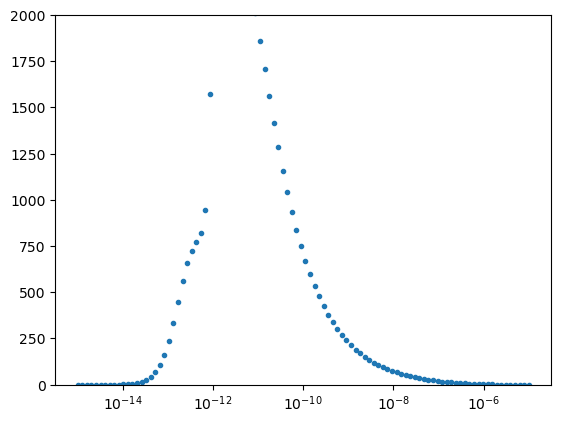

In [99]:
# plt.plot(t_hat, dgama_dt)
M = np.array(masses)
Nexp = np.array(nexp)*1e4
plt.plot(M , Nexp, marker='.', ls='')
plt.ylim(0,2e+3)
plt.xscale("log")
# plt.ylim(10**(-8),10**(-2))

In [104]:
# M

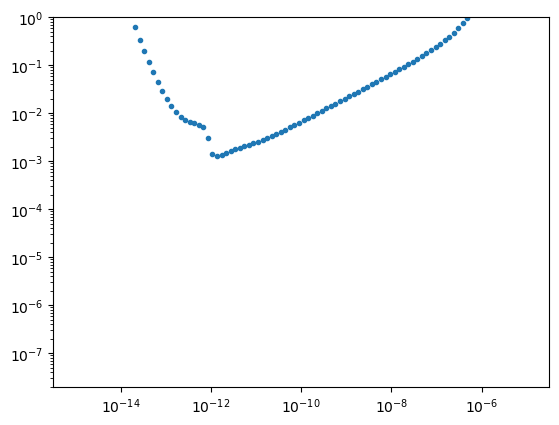

In [100]:
plt.plot(M , 4.74/Nexp, marker='.', ls='')
plt.ylim(2e-8,1)
plt.xscale("log")
plt.yscale("log")